# DataLab Cup 1 
[Kaggle](https://www.kaggle.com/competitions/2023-datalab-cup1-predicting-news-popularity/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

In [2]:
# load csv file
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print(f"{train.shape=}")
print(f"{train.columns=}")

train.shape=(27643, 3)
train.columns=Index(['Id', 'Popularity', 'Page content'], dtype='object')


#### Function Helper

hashing on the content,
sentiment on the topic
then append the day.

In [4]:
# train.iloc[27628,:]

In [5]:
# soup = BeautifulSoup(train['Page content'][27628], 'html.parser')
# print(soup.prettify())

In [6]:
def get_day_time(datetime_value):
    """Extract the day of the week and time from a datetime string."""
    day = {'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat':6}
    value = {}

    # Define a regular expression pattern to capture the day of the week and time
    pattern = r'^(\w+), (\d+ \w+ \d{4}) (\d+:\d+)'

    # Use re.search to find a match in the datetime value
    match = re.search(pattern, datetime_value)

    if match:
        value['Day'] = day[match.group(1)]/7
        time = match.group(3).split(':')
        value['Time'] = (int(time[0]) *60 + int(time[1])) / 1440.0
        # date = match.group(2)
    else:
        value['Day'] = 0
        value['Time'] = 0
        # date = np.nan
    
    return value
    
def chunk(iterable, chunk_size):
    """Generates lists of `chunk_size` elements from `iterable`.
    
    
    >>> list(chunk((2, 3, 5, 7), 3))
    [[2, 3, 5], [7]]
    >>> list(chunk((2, 3, 5, 7), 2))
    [[2, 3], [5, 7]]
    """
    iterable = iter(iterable)
    while True:
        chunk = []
        try:
            for _ in range(chunk_size):
                chunk.append(next(iterable))
            yield chunk
        except StopIteration:
            if chunk:
                yield chunk
            break

In [7]:
def preprocessor(text):
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text
def tokenizer(text):
    return re.split('\s+', text.strip())

from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords

def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]


nltk.download([
    "names",
    "stopwords",
    "movie_reviews",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",
])
stop = stopwords.words('english')
def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package names to /home/jojo/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jojo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jojo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


author is too hard

In [8]:
from icecream import ic
def preprocess(data):
    soup = BeautifulSoup(data, 'html.parser')

    title = soup.find('h1', class_='title').text
    day = "Mon"
    day_time = {'Day': 0, 'Time': 0}
    try:
        day = soup.find('time').get('datetime')
        day_time = get_day_time(day)
    except:
        pass

    content_element = soup.find('section', class_='article-content')
    content = content_element.text
    # links = soup.find_all('a')
    # try:
    #     links = len(links)
    # except:
    #     links = 0
    vid = len(soup.find_all('iframe'))
    arr = [title, len(content.split()), vid, day_time['Day'], day_time['Time']]

    for i in range(1):
        arr[i] = preprocessor(arr[i])

    return arr

In [9]:
# df_test = train['Page content'].apply(preprocess)

In [10]:
feat_2 = ['Title', 'Content', 'Video', 'Day', 'Time']
# df_test_pd = pd.DataFrame(df_test.to_list(), columns=feat_2)
# df_test_pd = pd.concat([df_test_pd, train[['Popularity']]], axis=1)

In [11]:
# df_test_pd[(df_test_pd['Video'] > 50)&(df_test_pd['Popularity'] ==-1)]

In [12]:
# df_test_pd[(df_test_pd['Popularity'] == -1) & (df_test_pd['Video'] == 0)]

In [13]:
# df_test_pd[(df_test_pd['Video'] == True) & (df_test_pd['Popularity'] == -1)]

In [14]:
# df_test_pd.shape

### Preprocessing

In [15]:
train_preprocess = train['Page content'].apply(preprocess)
test_preprocess = test['Page content'].apply(preprocess)


In [16]:
feat = feat_2.copy()
train_preprocess_df = pd.DataFrame(train_preprocess.to_list(), columns=feat)
test_preprocess_df = pd.DataFrame(test_preprocess.to_list(), columns=feat)

train_preprocess_df = pd.concat([train_preprocess_df, train[['Popularity']]], axis=1)
test_preprocess_df = pd.concat([test_preprocess_df], axis=1)

# scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_preprocess_df[['Content', 'Video']] = sc.fit_transform(train_preprocess_df[['Content', 'Video']])
test_preprocess_df[['Content', 'Video']] = sc.transform(test_preprocess_df[['Content', 'Video']])

In [17]:
train_preprocess_df

,Title,Content,Video,Day,Time,Popularity
0,nasa s grand challenge stop asteroids from des...,0.069157,0.000000,0.428571,0.627778,-1
1,google s new open source patent pledge we won ...,0.035626,0.000000,0.571429,0.736111,1
2,ballin 2014 nfl draft picks get to choose thei...,0.135355,0.274725,0.428571,0.802083,1
3,cameraperson fails deliver slapstick laughs,0.032298,0.230769,0.714286,0.101389,-1
4,nfl star helps young fan prove friendship with...,0.166913,0.010989,0.571429,0.146528,-1
...,...,...,...,...,...,...
27638,chief of usaid doesn t know who created cuban ...,0.035380,0.000000,0.285714,0.684722,-1
27639,photo of samsung s rumored virtual reality hea...,0.037106,0.000000,0.428571,0.043750,-1
27640,14 dogs that frankly cannot take the heat,0.018984,0.000000,0.571429,0.520833,-1
27641,yahoo earnings beat estimates but core problem...,0.051036,0.000000,0.285714,0.867361,-1


In [18]:
train_preprocess_df.to_csv('data/train_preprocess.csv', index=False)
test_preprocess_df.to_csv('data/test_preprocess.csv', index=False)

In [19]:
train_preprocess_df
test_preprocess_df

,Title,Content,Video,Day,Time
0,soccer star gets twitter death threats after t...,0.062993,0.076923,0.142857,0.824306
1,google glass gets an accessory store,0.015533,0.000000,0.571429,0.392361
2,ouya gaming console already sold out on amazon,0.018245,0.000000,0.285714,0.537500
3,between two ferns mocks oscar nominees,0.016889,0.043956,0.428571,0.145833
4,american sniper trailer looks like eastwood m...,0.025025,0.010989,0.714286,0.065278
...,...,...,...,...,...
11842,check out twitter co founders beautiful new of...,0.013190,0.000000,0.857143,0.875000
11843,fish out of water is an adorably addictive io...,0.067678,0.000000,0.571429,0.793750
11844,if music services influenced grammys this is w...,0.117973,0.241758,0.428571,0.984722
11845,google s nexus 7 comes to europe australia and...,0.014053,0.000000,0.428571,0.359028


In [20]:
train_preprocess_df['Title']

0        nasa s grand challenge stop asteroids from des...
1        google s new open source patent pledge we won ...
2        ballin 2014 nfl draft picks get to choose thei...
3             cameraperson fails deliver slapstick laughs 
4        nfl star helps young fan prove friendship with...
                               ...                        
27638    chief of usaid doesn t know who created cuban ...
27639    photo of samsung s rumored virtual reality hea...
27640           14 dogs that frankly cannot take the heat 
27641    yahoo earnings beat estimates but core problem...
27642    the winners of our curiocity contest tour aust...
Name: Title, Length: 27643, dtype: object

In [21]:
# import numpy as np
# import scipy as sp
# from sklearn.feature_extraction.text import HashingVectorizer
# from sklearn.compose import ColumnTransformer

# hash_vectorizer = HashingVectorizer(
#     decode_error='ignore', 
#     n_features=2**10,
#     preprocessor=None, 
#     tokenizer=tokenizer_stem_nostop
# )

# doc_hash = hash_vectorizer.transform(train_preprocess_df['Title'])
# doc_hash.shape
# # doc_hash[0]

In [22]:
# doc_hash

In [23]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import scipy

hashvec = HashingVectorizer(n_features=2**10,
                            preprocessor=None, tokenizer=tokenizer_stem_nostop)

# loss='log' gives logistic regression
clf = SGDClassifier(loss='log_loss', max_iter=20, tol=1e-3)
batch_size = 1000
X_train, y_train = train_preprocess_df['Title'].values, train_preprocess_df['Popularity'].values
X_train_2 = train_preprocess_df[['Content', 'Video', 'Day']].values
# print(X_train_2.iloc[:2,:])
stream_X = chunk(X_train, batch_size)
stream_X2 = chunk(X_train_2, batch_size)
stream_y = chunk(y_train, batch_size)

classes = np.array([-1, 1])
train_auc, val_auc = [], []
# we use one batch for training and another for validation in each iteration
iters = int((25000+batch_size-1)/(batch_size*2))

for i in range(iters):
    stream_x_chunk = next(stream_X)
    stream_x2_chunk = next(stream_X2)
    stream_y_chunk = next(stream_y)
    if stream_x_chunk is None:
        break
    stream_x_chunk = hashvec.transform(stream_x_chunk)

    stream_train_combined = np.concatenate((stream_x_chunk.toarray(), stream_x2_chunk), axis=1)
    clf.partial_fit(stream_train_combined, stream_y_chunk, classes=classes)
    train_auc.append(roc_auc_score(stream_y_chunk, clf.predict_proba(stream_train_combined)[:,1]))
    # print(X_train.shape, X_train_2.shape)   

    # # validate
    X_val, y_val = next(stream_X), next(stream_y)
    # print(X_val.shape, X_val_2.shape)
    X_val_2 = next(stream_X2)


    X_val = hashvec.transform(X_val)
    X_val_combined = np.concatenate((X_val.toarray(), X_val_2), axis=1)
    score = roc_auc_score(y_val, clf.predict_proba(X_val_combined)[:,1])
    val_auc.append(score)
    print('[{}/{}] {}'.format((i+1)*(batch_size*2), 25000, score))


[2000/25000] 0.49520424012425746
[4000/25000] 0.5396659331144702


[6000/25000] 0.49383397533590134
[8000/25000] 0.4997398501536885
[10000/25000] 0.5070591793527572
[12000/25000] 0.5098743554767972
[14000/25000] 0.4931637850663615
[16000/25000] 0.5291390490057641
[18000/25000] 0.502314453632912
[20000/25000] 0.5017360621030346
[22000/25000] 0.5210801421618851
[24000/25000] 0.5292884686154978


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

X_train_combined_ = np.concatenate((hashvec.transform(X_train).toarray(), X_train_2), axis=1)

scores = cross_val_score(estimator=RandomForestRegressor(max_depth=4, random_state=0),
                         X=X_train_combined_, y=y_train,
                         cv=10, scoring='roc_auc')

In [29]:
forest = RandomForestRegressor(max_depth=4, random_state=0)
forest.fit(X_train_combined_, y_train)

RandomForestRegressor(max_depth=4, random_state=0)

In [34]:
X_test = hashvec.transform(test_preprocess_df['Title'])
X_test_2 = test_preprocess_df[['Content', 'Video', 'Day']].values
X_val_combined = np.concatenate((X_test.toarray(), X_test_2), axis=1)
y_pred = forest.predict(X_val_combined)
y_pred = (y_pred + 1) / 2
print(y_pred)


[0.46148341 0.48401076 0.46148341 ... 0.46197225 0.46526525 0.46197225]


In [35]:
# write to csv
df = pd.DataFrame({'Id': test['Id'], 'Popularity': y_pred})
df.to_csv('data/submission.csv', index=False)

# Unused

In [ ]:
X_test = test_preprocess_new['Content']
X_test = hashvec.transform(X_test)
value = clf.predict_proba(X_test)[:,1]
value

In [28]:
scores

array([0.57508175, 0.55360073, 0.54464689, 0.55504806, 0.5576876 ,
       0.57226605, 0.53132727, 0.56208033, 0.54998534, 0.56133107])

In [ ]:
test_preprocess_df

,Title,Content,Video,Day,Time
0,soccer star gets twitter death threats after t...,0.062993,0.076923,0.142857,0.824306
1,google glass gets an accessory store,0.015533,0.000000,0.571429,0.392361
2,ouya gaming console already sold out on amazon,0.018245,0.000000,0.285714,0.537500
3,between two ferns mocks oscar nominees,0.016889,0.043956,0.428571,0.145833
4,american sniper trailer looks like eastwood m...,0.025025,0.010989,0.714286,0.065278
...,...,...,...,...,...
11842,check out twitter co founders beautiful new of...,0.013190,0.000000,0.857143,0.875000
11843,fish out of water is an adorably addictive io...,0.067678,0.000000,0.571429,0.793750
11844,if music services influenced grammys this is w...,0.117973,0.241758,0.428571,0.984722
11845,google s nexus 7 comes to europe australia and...,0.014053,0.000000,0.428571,0.359028


In [ ]:
X_test = hashvec.transform(test_preprocess_df['Title'])
X_test_2 = test_preprocess_df[['Content', 'Video', 'Day', 'Time']].values
X_val_combined = np.concatenate((X_test.toarray(), X_test_2), axis=1)
y_pred = clf.predict_proba(X_val_combined)[:,1]
y_pred

array([0.60918488, 0.78922888, 0.71792457, ..., 0.92055328, 0.79249171,
       0.73539595])

In [ ]:
# write to csv
df = pd.DataFrame({'Id': test['Id'], 'Popularity': y_pred})
df.to_csv('data/submission.csv', index=False)

# Try Title Sentiment Analysis

In [ ]:
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()

In [ ]:
# classifier = nltk.classify.SklearnClassifier(LogisticRegression())
# classifier.train(features)
# test_preprocess_df['Popularity'] = test_preprocess_df['Title'].apply(lambda x: classifier.prob_classify(extract_features(x)))


In [ ]:
# test_predict = test_preprocess_df['Popularity'].apply(lambda x: x.prob(1))

In [ ]:
# test_predict.to_csv('data/test_predict.csv', index=False)

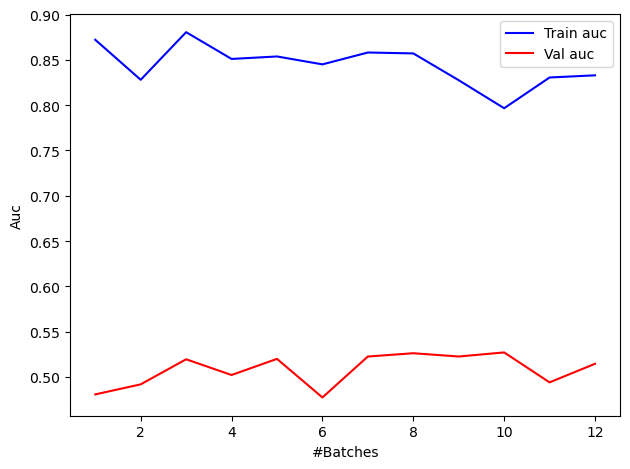

In [ ]:
# import os
# if not os.path.exists('output'):
#     os.mkdir('output')

# import matplotlib.pyplot as plt

# plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
# plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
# plt.legend(loc="best")
# plt.xlabel('#Batches')
# plt.ylabel('Auc')
# plt.tight_layout()
# plt.savefig('./output/fig-out-of-core.png', dpi=300)
# plt.show()

In [ ]:
# X_test = test_preprocess_new['Content']
# X_test = hashvec.transform(X_test)
# value = clf.predict_proba(X_test)[:,1]
# value

array([0.59867913, 0.71039762, 0.20938858, ..., 0.52613739, 0.40480274,
       0.42310348])

In [ ]:
# file = pd.concat([test[['Id']], pd.DataFrame(value, columns=['Popularity'])], axis=1)
# file

# file.to_csv('data/submission.csv', index=False)